# DE-test-sanity-checking
1.12.23

Sanity checking, making sure the partitioning code is doing what I think its doing. 
Can also play around with the MNAR partitioning parameters to withhold a certain fraction of values. 

Also sanity checking my Gaussian random sample and sample min impute methods, just to make sure
they're doing what they're supposed to be doing. 

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# my modules
sys.path.append('../../../../bin/')
import util_functions

# plotting templates
sns.set(context="talk", style="ticks") 
pal = sns.color_palette()

#### Configs

In [2]:
# partitioning params
val_frac = 0.3
test_frac = 0.0
# setting this to 0 ensures that no peptides will be filtered out
min_present = 0     # during partitioning
q_anchor=0.35  # these three for MNAR partition 
t_std=0.45 
brnl_prob=0.75

# NMF training params
batch_size = 64

# the random number generator
rng = np.random.default_rng(seed=18)

# the random state for the partition
split_rand_state = 18

#### Read in the SMTG data, and divide into two experimental groups

In [3]:
# read in 
cond1_df = pd.read_csv(
            "../../2022-10-31_SMTG_data/data/SMTG-ADD-quants.csv")
cond2_df = pd.read_csv(
            "../../2022-10-31_SMTG_data/data/SMTG-HCF-low-quants.csv")

# get the list of peptide IDs, or rather transition group IDs
    # these will be the same for the two datasets
peptide_ids = np.array(cond1_df["pids"])

# now remove the peptide ID columns
to_remove = ["pids"]
cond1_df = cond1_df.drop(to_remove, axis=1)
cond2_df = cond2_df.drop(to_remove, axis=1)

# convert to numpy arrays
cond1_quants = np.array(cond1_df)
cond2_quants = np.array(cond2_df)

print("condition 1 quants: ", cond1_quants.shape)
print("condition 2 quants: ", cond2_quants.shape)

condition 1 quants:  (32614, 9)
condition 2 quants:  (32614, 9)


#### Combine, and keep track of the column cutoffs

In [4]:
# create the combined matrix, to use for imputation 
comb_quants = np.concatenate([cond1_quants, cond2_quants], axis=1)

# this is for eventually separating the reconstructed matrices 
    # into normal and tumor matrices
cols_cutoff = cond1_quants.shape[1]

#### Partition 

In [5]:
# MCAR partition 
# train, val, test = util_functions.split(
#                                     comb_quants, 
#                                     val_frac=val_frac,
#                                     test_frac=test_frac, 
#                                     min_present=min_present,
#                                     random_state=split_rand_state,
# )
# MNAR partition 
train, val = util_functions.MNAR_partition_thresholds_matrix(
                                    comb_quants, 
                                    q_anchor=q_anchor, 
                                    t_std=t_std, 
                                    brnl_prob=brnl_prob, 
                                    min_pres=min_present,
                                    rand_state=split_rand_state,
)

#### Get the optimal number of batches

In [6]:
# get the optimal number of batches for training
if len(~np.isnan(train)) > 100:
    n_batches = int(np.floor(len(~np.isnan(train)) / batch_size))
    # setting the minimum n_batches to 100
    n_batches = max(n_batches, 100) 
else: 
    n_batches = 1

#### Get the missingness fractions

In [7]:
orig_mv_frac = np.count_nonzero(np.isnan(comb_quants)) / comb_quants.size
train_mv_frac = np.count_nonzero(np.isnan(train)) / train.size
val_mv_frac = np.count_nonzero(np.isnan(val)) / val.size

print("mv frac original: ", np.around(orig_mv_frac, decimals=3))
print("mv frac train: ", np.around(train_mv_frac, decimals=3))
print("mv frac validation: ", np.around(val_mv_frac, decimals=3))

mv frac original:  0.0
mv frac train:  0.275
mv frac validation:  0.725


#### Plotting the distributions of the partitions

Text(0, 0.5, 'Counts')

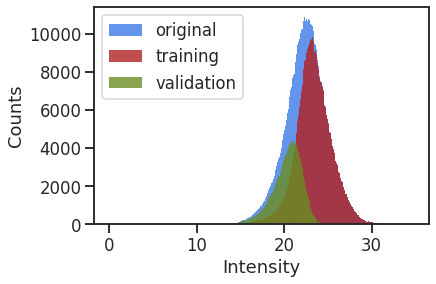

In [8]:
# flatten
quants_rav = comb_quants.ravel()
train_rav = train.ravel()
val_rav = val.ravel()

# get the present values from the original matrix
p_quants_nans = np.isnan(quants_rav)
p_quants_present = quants_rav[~p_quants_nans]

# get present values from the training matrix
train_nans = np.isnan(train_rav)
train_present = train_rav[~train_nans]

# get present values from the validation matrix
val_nans = np.isnan(val_rav)
val_present = val_rav[~val_nans]

quants_max = np.max(p_quants_present)
quants_min = np.min(p_quants_present)

bins_range = np.arange(0, quants_max, 0.1)

plt.figure()
plt.hist(p_quants_present, density=False, bins=bins_range, linewidth=0.01,
         color='cornflowerblue', edgecolor='cornflowerblue', alpha=1.0, label="original")
plt.hist(train_present, density=False, bins=bins_range, linewidth=0.01, 
         color='firebrick', edgecolor='firebrick', alpha=0.8, label="training")
plt.hist(val_present, density=False, bins=bins_range, linewidth=0.01,
        color='olivedrab', edgecolor='olivedrab', alpha=0.8, label="validation")

plt.minorticks_off()

plt.legend()
plt.xlabel("Intensity")
plt.ylabel("Counts")

***

## Lets look at Gaussian random sample impute, because that seems to be causing problems. 

#### Rand impute
Ok, I think this is working now. 

In [9]:
col_min = np.nanmin(train, axis=0)

train_mean = np.nanmean(train)
train_sd = np.nanstd(train)

nan_idx = np.where(np.isnan(train))
std_recon = train.copy()

# how many total MVs? 
n_mv = len(nan_idx[0])

# fill in the MVs with random draws 
std_recon[nan_idx] = rng.normal(
                            loc=np.mean(col_min), 
                            scale=np.std(col_min), 
                            size=n_mv
)
# don't want negative values
std_recon = np.abs(std_recon)

## Lets look at sample min impute as well 
Just to sanity check. Keep in mind that we could just as easily do a row (peptide) min rather than col (sample) min. I think the more common approach is the sample min, so maybe thats the best starting point. 

#### Min impute

In [12]:
col_min = np.nanmin(train, axis=0)
nan_idx = np.where(np.isnan(train))
min_recon = train.copy()
# nan_idx[1] -> take index of column
min_recon[nan_idx] = np.take(col_min, nan_idx[1]) 